<a href="https://colab.research.google.com/github/nawaz0x1/CS231N-Computer-Vision/blob/master/Lecture%208/Vision%20Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer (ViT) on CIFAR-10 using PyTorch

**Vision Transformer**: A architecture that treats images as sequences of patches and applies the Transformer architecture to computer vision.

### Key Components:
1. **Patch Embedding**: Split image into patches and linearly embed them
2. **Position Encoding**: Add learnable position embeddings to patches
3. **Transformer Encoder**: Multi-head self-attention + MLP blocks
4. **Classification Head**: Final MLP for class prediction

### Mathematical Foundation:
- **Patch Embedding**: `patches = reshape(image, [H/P × W/P, P²×C]); embeddings = patches @ E`
- **Self-Attention**: `Attention(Q,K,V) = softmax(QK^T/√d_k)V`
- **Multi-Head Attention**: `MultiHead = Concat(head₁,...,head_h)W^O`
- **Transformer Block**: `x' = x + MSA(LN(x)); x'' = x' + MLP(LN(x'))`

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tarfile
import urllib.request
import os
import time
import math
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, matthews_corrcoef, confusion_matrix,
                           roc_auc_score, roc_curve, classification_report,
                           log_loss)

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

Using device: cuda
GPU: Tesla T4


## CIFAR-10 Dataset

### About CIFAR-10:
- **Created by**: Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton at the University of Toronto
- **Source**: https://www.cs.toronto.edu/~kriz/cifar.html
- **Images**: 32×32 color images
- **Classes**: 10
- **Size**: 60,000 images total (50,000 training + 10,000 testing)

### Classes:
1. **Airplane** - Various aircraft types
2. **Automobile** - Cars, trucks, and other vehicles  
3. **Bird** - Different bird species
4. **Cat** - Domestic cats in various poses
5. **Deer** - Wild deer and similar animals
6. **Dog** - Various dog breeds
7. **Frog** - Frogs and toads
8. **Horse** - Horses in different settings
9. **Ship** - Naval vessels and boats
10. **Truck** - Large vehicles and trucks

## Download and Load Dataset

In [2]:
def download_cifar10():
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    extracted_dir = "cifar-10-batches-py"

    if not os.path.exists("data"):
        os.makedirs("data")

    filepath = os.path.join("data", filename)
    extracted_path = os.path.join("data", extracted_dir)

    if os.path.exists(extracted_path):
        print("CIFAR-10 dataset already exists!")
        return extracted_path

    if not os.path.exists(filepath):
        print("Downloading CIFAR-10 dataset...")
        print(f"   Source: {url}")
        urllib.request.urlretrieve(url, filepath)
        print("Download completed!")

    print("Extracting dataset...")
    with tarfile.open(filepath, 'r:gz') as tar:
        tar.extractall("data")
    print("Extraction completed!")

    return extracted_path

def load_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')

    data = batch[b'data']
    labels = batch[b'labels']
    data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return data, labels

def load_cifar10(data_dir):
    print("Loading CIFAR-10 dataset...")

    train_data = []
    train_labels = []

    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        data, labels = load_batch(batch_file)
        train_data.append(data)
        train_labels.extend(labels)

    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.array(train_labels)

    test_file = os.path.join(data_dir, 'test_batch')
    test_data, test_labels = load_batch(test_file)
    test_labels = np.array(test_labels)

    meta_file = os.path.join(data_dir, 'batches.meta')
    with open(meta_file, 'rb') as f:
        meta = pickle.load(f, encoding='bytes')
    class_names = [name.decode('utf-8') for name in meta[b'label_names']]

    print("Dataset loaded successfully!")

    return (train_data, train_labels), (test_data, test_labels), class_names

In [3]:
data_dir = download_cifar10()
(X_train_full, y_train_full), (X_test, y_test), class_names = load_cifar10(data_dir)

CIFAR-10 dataset already exists!
Loading CIFAR-10 dataset...
Dataset loaded successfully!


## Dataset Information and Statistics

In [4]:
print(f"Training samples: {X_train_full.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")
print(f"Image shape: {X_train_full.shape[1:]} (Height × Width × Channels)")
print(f"Total pixels per image: {np.prod(X_train_full.shape[1:]):,}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

unique, counts = np.unique(y_train_full, return_counts=True)
print(f"\nClass Distribution (Training Set):")
for i, (class_idx, count) in enumerate(zip(unique, counts)):
    print(f"   {class_idx}. {class_names[class_idx]:12s}: {count:,} samples ({count/len(y_train_full)*100:.1f}%)")

is_balanced = len(set(counts)) == 1
print(f"\nDataset is {'balanced' if is_balanced else 'imbalanced'}")

print(f"\nData characteristics:")
print(f"   Data type: {X_train_full.dtype}")
print(f"   Pixel value range: [{X_train_full.min()}, {X_train_full.max()}]")
print(f"   Label type: {y_train_full.dtype}")
print(f"   Label range: [{y_train_full.min()}, {y_train_full.max()}]")

Training samples: 50,000
Test samples: 10,000
Image shape: (32, 32, 3) (Height × Width × Channels)
Total pixels per image: 3,072
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Class Distribution (Training Set):
   0. airplane    : 5,000 samples (10.0%)
   1. automobile  : 5,000 samples (10.0%)
   2. bird        : 5,000 samples (10.0%)
   3. cat         : 5,000 samples (10.0%)
   4. deer        : 5,000 samples (10.0%)
   5. dog         : 5,000 samples (10.0%)
   6. frog        : 5,000 samples (10.0%)
   7. horse       : 5,000 samples (10.0%)
   8. ship        : 5,000 samples (10.0%)
   9. truck       : 5,000 samples (10.0%)

Dataset is balanced

Data characteristics:
   Data type: uint8
   Pixel value range: [0, 255]
   Label type: int64
   Label range: [0, 9]


## Visualize Sample Images

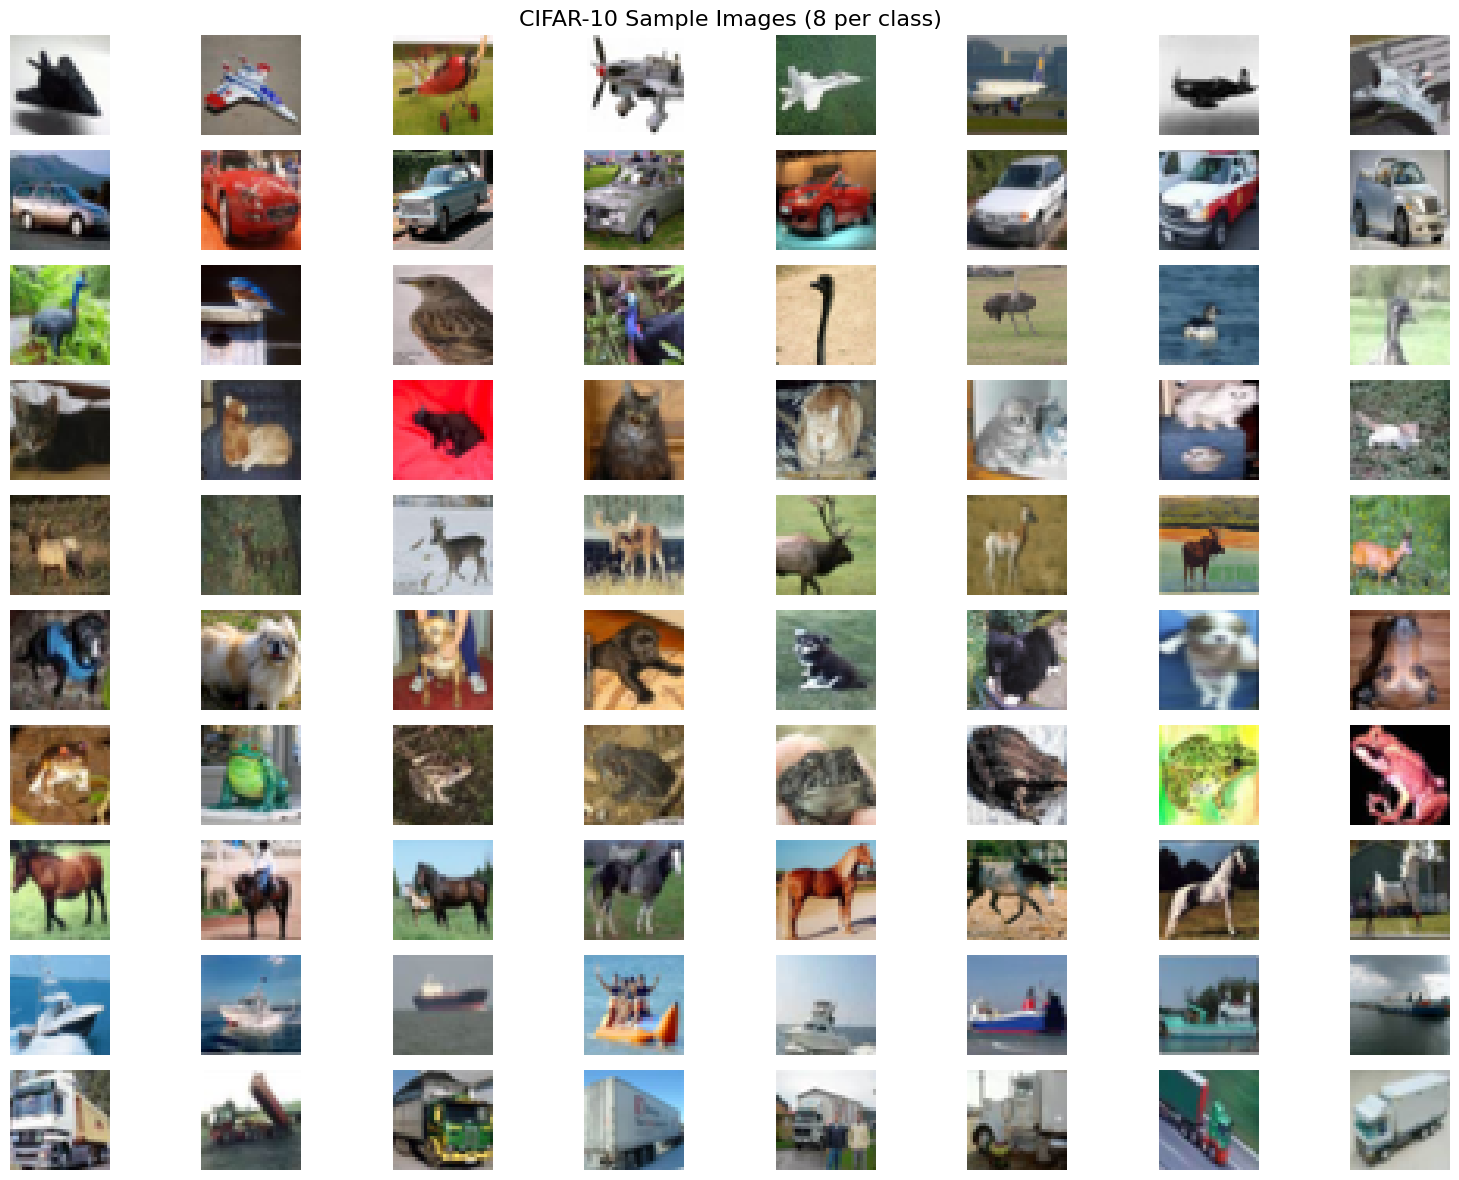

In [5]:
plt.figure(figsize=(16, 12))

for class_idx in range(10):
    class_indices = np.where(y_train_full == class_idx)[0]

    for i in range(8):
        plt.subplot(10, 8, class_idx * 8 + i + 1)
        image = X_train_full[class_indices[i]]

        plt.imshow(image)
        if i == 0:
            plt.ylabel(f'{class_idx}: {class_names[class_idx]}', rotation=0,
                      ha='right', va='center', fontsize=10)
        plt.axis('off')

plt.suptitle('CIFAR-10 Sample Images (8 per class)', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

## Data Preprocessing for Vision Transformer

### ViT Preprocessing Pipeline:
1. **Normalization**: Scale pixel values to [0, 1]
2. **Standardization**: Apply ImageNet normalization (mean, std per channel)
3. **Patch Splitting**: Will be handled by the ViT model
4. **Train/Validation Split**: 80%-20% split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

print(f"Dataset Splits:")
print(f"   Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_train_full)*100:.1f}%)")
print(f"   Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X_train_full)*100:.1f}%)")
print(f"   Test set: {X_test.shape[0]:,} samples")

# Normalization to [0, 1]
print(f"\nNormalization:")
print(f"   Original range: [{X_train.min()}, {X_train.max()}]")

X_train_norm = X_train.astype(np.float32) / 255.0
X_val_norm = X_val.astype(np.float32) / 255.0
X_test_norm = X_test.astype(np.float32) / 255.0

print(f"   Normalized range: [{X_train_norm.min():.3f}, {X_train_norm.max():.3f}]")

# Convert to PyTorch tensors and change to CHW format (channels first)
print(f"\nConverting to PyTorch tensors (CHW format):")
print(f"   Original shape (HWC): {X_train_norm.shape}")

X_train_tensor = torch.FloatTensor(X_train_norm).permute(0, 3, 1, 2).to(device)  # NHWC -> NCHW
X_val_tensor = torch.FloatTensor(X_val_norm).permute(0, 3, 1, 2).to(device)
X_test_tensor = torch.FloatTensor(X_test_norm).permute(0, 3, 1, 2).to(device)

y_train_tensor = torch.LongTensor(y_train).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

print(f"   Final tensor shape (CHW): {X_train_tensor.shape}")
print(f"   Device: {X_train_tensor.device}")

# Normalization
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

X_train_normalized = (X_train_tensor - imagenet_mean) / imagenet_std
X_val_normalized = (X_val_tensor - imagenet_mean) / imagenet_std
X_test_normalized = (X_test_tensor - imagenet_mean) / imagenet_std

print(f"\nImageNet Standardization:")
print(f"   Mean: {imagenet_mean.squeeze()}")
print(f"   Std: {imagenet_std.squeeze()}")
print(f"   Final range: [{X_train_normalized.min():.3f}, {X_train_normalized.max():.3f}]")

print(f"\nClass Distribution Verification:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
val_unique, val_counts = np.unique(y_val, return_counts=True)

print("Training set balance:")
for i, count in enumerate(train_counts):
    print(f"   Class {i}: {count:,} samples ({count/len(y_train)*100:.1f}%)")

print("Validation set balance:")
for i, count in enumerate(val_counts):
    print(f"   Class {i}: {count:,} samples ({count/len(y_val)*100:.1f}%)")

Dataset Splits:
   Training set: 40,000 samples (80.0%)
   Validation set: 10,000 samples (20.0%)
   Test set: 10,000 samples

Normalization:
   Original range: [0, 255]
   Normalized range: [0.000, 1.000]

Converting to PyTorch tensors (CHW format):
   Original shape (HWC): (40000, 32, 32, 3)
   Final tensor shape (CHW): torch.Size([40000, 3, 32, 32])
   Device: cuda:0

ImageNet Standardization:
   Mean: tensor([0.4850, 0.4560, 0.4060], device='cuda:0')
   Std: tensor([0.2290, 0.2240, 0.2250], device='cuda:0')
   Final range: [-2.118, 2.640]

Class Distribution Verification:
Training set balance:
   Class 0: 4,000 samples (10.0%)
   Class 1: 4,000 samples (10.0%)
   Class 2: 4,000 samples (10.0%)
   Class 3: 4,000 samples (10.0%)
   Class 4: 4,000 samples (10.0%)
   Class 5: 4,000 samples (10.0%)
   Class 6: 4,000 samples (10.0%)
   Class 7: 4,000 samples (10.0%)
   Class 8: 4,000 samples (10.0%)
   Class 9: 4,000 samples (10.0%)
Validation set balance:
   Class 0: 1,000 samples (10.0

## Vision Transformer Implementation

### ViT Architecture Components:

1. **Patch Embedding**: Linear projection of flattened patches
2. **Position Embedding**: Learnable position encodings
3. **Transformer Encoder**: Multi-head self-attention + Feed-forward
4. **Classification Head**: Layer normalization + Linear layer

### Mathematical Details:

**Patch Embedding:**
```
Input: [N, C, H, W] → Patches: [N, num_patches, patch_dim]
patch_dim = patch_size² × channels
```

**Self-Attention:**
```
Q = X @ W_q, K = X @ W_k, V = X @ W_v
Attention(Q,K,V) = softmax(QK^T / √d_k) @ V
```

**Transformer Block:**
```
x' = x + MultiHeadAttention(LayerNorm(x))
x'' = x' + MLP(LayerNorm(x'))
```

In [7]:
class PatchEmbedding(nn.Module):

    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim

        self.num_patches = (img_size // patch_size) ** 2

        self.projection = nn.Linear(patch_size * patch_size * in_channels, embed_dim)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(batch_size, self.num_patches, -1)
        x = self.projection(x)

        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)
        self.out_linear = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape

        Q = self.q_linear(x)  # [batch_size, seq_len, embed_dim]
        K = self.k_linear(x)
        V = self.v_linear(x)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)

        attention_output = torch.matmul(attention_probs, V)

        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, embed_dim
        )

        output = self.out_linear(attention_output)

        return output, attention_probs

class TransformerBlock(nn.Module):

    def __init__(self, embed_dim, num_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = MultiHeadSelfAttention(embed_dim, num_heads, dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        attention_output, attention_weights = self.attention(self.norm1(x))
        x = x + attention_output
        mlp_output = self.mlp(self.norm2(x))
        x = x + mlp_output

        return x, attention_weights

class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=192, num_layers=12, num_heads=3, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_layers = num_layers

        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.num_patches = self.patch_embedding.num_patches

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        self.position_embeddings = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

        self.dropout = nn.Dropout(dropout)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self.init_weights()

    def init_weights(self):
        nn.init.trunc_normal_(self.position_embeddings, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.trunc_normal_(module.weight, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LayerNorm):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embedding(x)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)


        attention_weights = []
        for block in self.transformer_blocks:
            x, attn_weights = block(x)
            attention_weights.append(attn_weights)

        x = self.norm(x)
        cls_token_final = x[:, 0]
        logits = self.head(cls_token_final)

        return logits, attention_weights

    def get_attention_maps(self, x, layer_idx=-1):
        self.eval()
        with torch.no_grad():
            _, attention_weights = self.forward(x)
            if layer_idx == -1:
                return attention_weights[-1]  # Last layer
            else:
                return attention_weights[layer_idx]

## Model Configuration and Creation

In [8]:
config = {
    'img_size': 32,          # CIFAR-10 image size
    'patch_size': 4,         # 4x4 patches (32/4 = 8 patches per side)
    'in_channels': 3,        # RGB channels
    'num_classes': 10,       # CIFAR-10 classes
    'embed_dim': 192,        # Embedding dimension (smaller for CIFAR-10)
    'num_layers': 8,         # Number of transformer layers
    'num_heads': 12,         # Number of attention heads (embed_dim must be divisible)
    'mlp_ratio': 4,          # MLP hidden size ratio
    'dropout': 0.2           # Dropout rate
}


model = VisionTransformer(**config).to(device)

print("Vision Transformer Architecture:")
print("=" * 50)
print(f"Image size: {config['img_size']}×{config['img_size']}")
print(f"Patch size: {config['patch_size']}×{config['patch_size']}")
print(f"Number of patches: {(config['img_size'] // config['patch_size'])**2}")
print(f"Embedding dimension: {config['embed_dim']}")
print(f"Number of layers: {config['num_layers']}")
print(f"Number of attention heads: {config['num_heads']}")
print(f"Head dimension: {config['embed_dim'] // config['num_heads']}")


total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Parameters:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")


patch_embed_params = sum(p.numel() for p in model.patch_embedding.parameters())
pos_embed_params = model.position_embeddings.numel() + model.cls_token.numel()
transformer_params = sum(p.numel() for p in model.transformer_blocks.parameters())
head_params = sum(p.numel() for p in model.head.parameters()) + sum(p.numel() for p in model.norm.parameters())

print(f"\nParameter Breakdown:")
print(f"   Patch embedding: {patch_embed_params:,}")
print(f"   Position embeddings: {pos_embed_params:,}")
print(f"   Transformer blocks: {transformer_params:,}")
print(f"   Classification head: {head_params:,}")

print(f"\nModel Complexity Analysis:")
print(f"   Parameters: {total_params:,}")
print(f"   Training samples: {len(X_train):,}")
print(f"   Parameter-to-sample ratio: {total_params/len(X_train):.3f}")


print(f"\nTesting forward pass:")
with torch.no_grad():
    sample_batch = X_train_normalized[:4]
    logits, attention_weights = model(sample_batch)
    print(f"   Input shape: {sample_batch.shape}")
    print(f"   Output logits shape: {logits.shape}")
    print(f"   Number of attention layers: {len(attention_weights)}")
    print(f"   Attention weights shape (last layer): {attention_weights[-1].shape}")
    print(f"   Attention heads: {attention_weights[-1].shape[1]}")
    print(f"   Sequence length: {attention_weights[-1].shape[2]} (patches + cls_token)")

print(f"\nMemory Usage:")
model_memory = sum(p.numel() * p.element_size() for p in model.parameters())
print(f"   Model memory: {model_memory / (1024**2):.1f} MB")
print(f"   Training data memory: {X_train_normalized.element_size() * X_train_normalized.nelement() / (1024**2):.1f} MB")

Vision Transformer Architecture:
Image size: 32×32
Patch size: 4×4
Number of patches: 64
Embedding dimension: 192
Number of layers: 8
Number of attention heads: 12
Head dimension: 16

Model Parameters:
   Total parameters: 3,583,306
   Trainable parameters: 3,583,306

Parameter Breakdown:
   Patch embedding: 9,408
   Position embeddings: 12,672
   Transformer blocks: 3,558,912
   Classification head: 2,314

Model Complexity Analysis:
   Parameters: 3,583,306
   Training samples: 40,000
   Parameter-to-sample ratio: 89.583

Testing forward pass:
   Input shape: torch.Size([4, 3, 32, 32])
   Output logits shape: torch.Size([4, 10])
   Number of attention layers: 8
   Attention weights shape (last layer): torch.Size([4, 12, 65, 65])
   Attention heads: 12
   Sequence length: 65 (patches + cls_token)

Memory Usage:
   Model memory: 13.7 MB
   Training data memory: 468.8 MB


## Data Loaders

In [9]:
batch_size = 1024

train_dataset = TensorDataset(X_train_normalized, y_train_tensor)
val_dataset = TensorDataset(X_val_normalized, y_val_tensor)
test_dataset = TensorDataset(X_test_normalized, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Data Loaders created:")
print(f"   Batch size: {batch_size}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

batch_memory = batch_size * X_train_normalized.shape[1] * X_train_normalized.shape[2] * X_train_normalized.shape[3] * 4  # 4 bytes per float32
print(f"   Memory per batch: {batch_memory / (1024**2):.1f} MB")

Data Loaders created:
   Batch size: 1024
   Training batches: 40
   Validation batches: 10
   Test batches: 10
   Memory per batch: 12.0 MB


## Training Configuration

In [10]:
train_config = {
    'learning_rate': 3e-4,       # Common for Vision Transformers
    'weight_decay': 1e-4,        # L2 regularization
    'num_epochs': 100,           # More epochs for ViT convergence
    'patience': 15,              # Early stopping patience
    'min_delta': 1e-4,           # Minimum improvement for early stopping
    'warmup_epochs': 10          # Learning rate warmup
}

print("Training Configuration:")
for key, value in train_config.items():
    print(f"   {key}: {value}")

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(),
                       lr=train_config['learning_rate'],
                       weight_decay=train_config['weight_decay'])


def get_lr_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            return 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, train_config['warmup_epochs'], train_config['num_epochs'])

print(f"\nOptimizer: {optimizer}")
print(f"Learning Rate Scheduler: Warmup + Cosine Annealing")
print(f"Loss Function: {criterion}")


history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

Training Configuration:
   learning_rate: 0.0003
   weight_decay: 0.0001
   num_epochs: 100
   patience: 15
   min_delta: 0.0001
   warmup_epochs: 10

Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0003
    lr: 2.9999999999999997e-05
    maximize: False
    weight_decay: 0.0001
)
Learning Rate Scheduler: Warmup + Cosine Annealing
Loss Function: CrossEntropyLoss()


## Training Functions

In [11]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        outputs, _ = model(data)
        loss = criterion(outputs, target)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_samples

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            outputs, _ = model(data)
            loss = criterion(outputs, target)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += target.size(0)
            correct_predictions += (predicted == target).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct_predictions / total_samples

    return epoch_loss, epoch_acc

def early_stopping_check(val_losses, patience, min_delta):
    if len(val_losses) <= patience:
        return False

    best_loss = min(val_losses)

    epochs_without_improvement = 0
    for i in range(len(val_losses) - 1, -1, -1):
        if val_losses[i] <= best_loss + min_delta:
            break
        epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            return True

    return False

## Model Training with Progress Tracking

In [12]:
best_val_acc = 0.0
best_epoch = 0
training_start_time = time.time()

print("Starting Vision Transformer Training...")
print("=" * 60)

for epoch in range(train_config['num_epochs']):
    epoch_start_time = time.time()

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])

    epoch_time = time.time() - epoch_start_time

    print(f"Epoch {epoch+1:3d}/{train_config['num_epochs']:3d} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Time: {epoch_time:.2f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'config': config,
            'train_config': train_config
        }, 'best_model.pth')
        print(f"         → New best validation accuracy: {val_acc:.4f}")

    if early_stopping_check(history['val_loss'], train_config['patience'], train_config['min_delta']):
        print(f"\nEarly stopping triggered after epoch {epoch+1}")
        print(f"No improvement for {train_config['patience']} consecutive epochs")
        break

training_time = time.time() - training_start_time

print("\n" + "=" * 60)
print("Training Completed!")
print(f"Total training time: {training_time:.2f} seconds ({training_time/60:.1f} minutes)")
print(f"Best validation accuracy: {best_val_acc:.4f} (epoch {best_epoch})")
print(f"Final learning rate: {optimizer.param_groups[0]['lr']:.6f}")
print(f"Total epochs completed: {len(history['train_loss'])}")

Starting Vision Transformer Training...
Epoch   1/100 | Train Loss: 2.2254 | Train Acc: 0.1751 | Val Loss: 2.1533 | Val Acc: 0.2090 | LR: 0.000060 | Time: 41.47s
         → New best validation accuracy: 0.2090
Epoch   2/100 | Train Loss: 2.0868 | Train Acc: 0.2320 | Val Loss: 2.0582 | Val Acc: 0.2446 | LR: 0.000090 | Time: 40.88s
         → New best validation accuracy: 0.2446
Epoch   3/100 | Train Loss: 1.9609 | Train Acc: 0.2767 | Val Loss: 1.9840 | Val Acc: 0.2735 | LR: 0.000120 | Time: 40.98s
         → New best validation accuracy: 0.2735
Epoch   4/100 | Train Loss: 1.9067 | Train Acc: 0.2982 | Val Loss: 1.9575 | Val Acc: 0.2807 | LR: 0.000150 | Time: 40.70s
         → New best validation accuracy: 0.2807
Epoch   5/100 | Train Loss: 1.8629 | Train Acc: 0.3067 | Val Loss: 1.9685 | Val Acc: 0.2762 | LR: 0.000180 | Time: 40.92s
Epoch   6/100 | Train Loss: 1.8217 | Train Acc: 0.3219 | Val Loss: 1.9374 | Val Acc: 0.3022 | LR: 0.000210 | Time: 41.08s
         → New best validation accur

## Training Progress Visualization

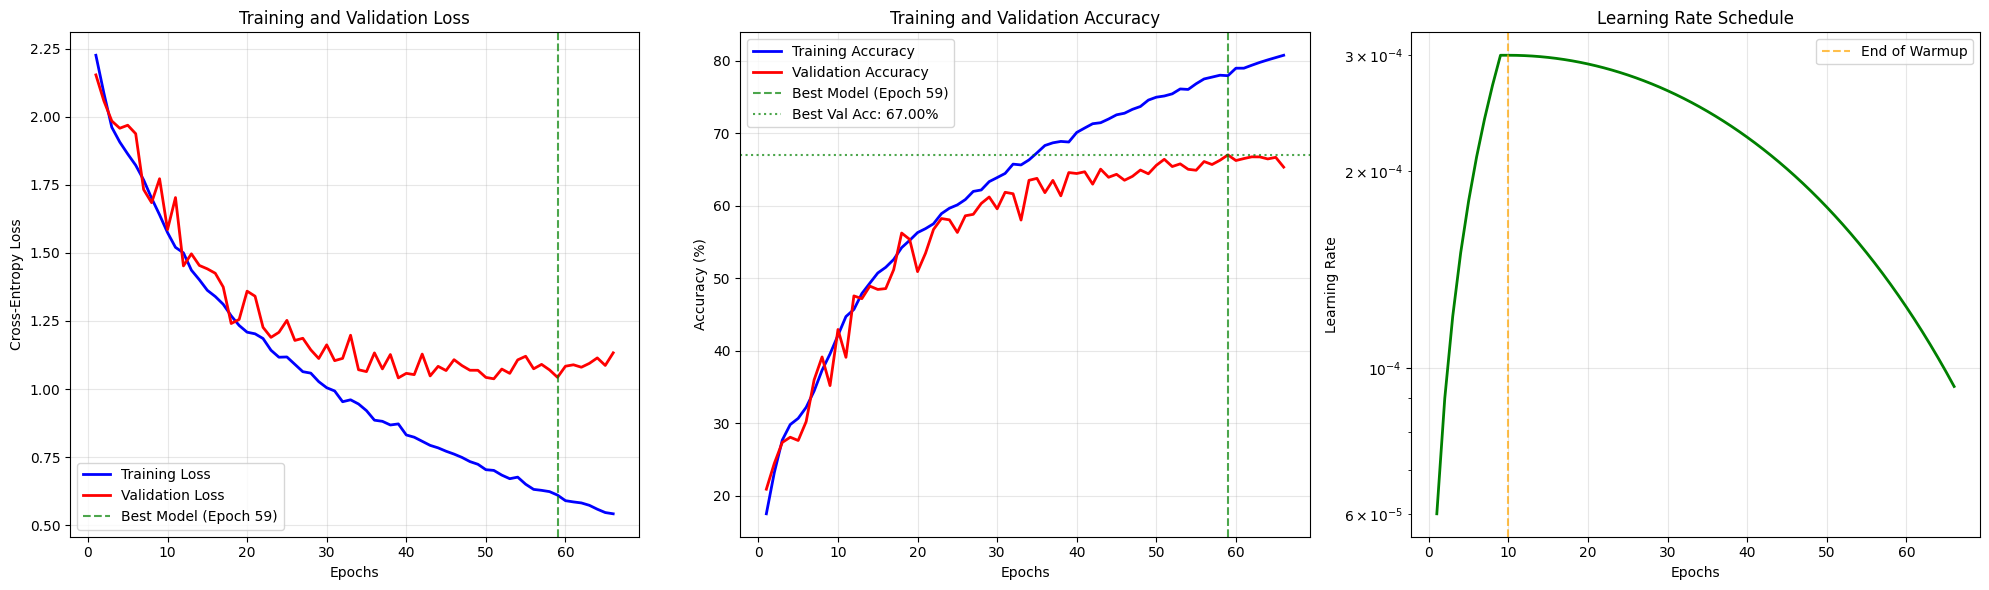

Training Summary:
   Final training accuracy: 80.75%
   Final validation accuracy: 65.32%
   Best validation accuracy: 67.00%
   Training-validation gap: 15.43%
   Final training loss: 0.5421
   Final validation loss: 1.1330

Learning Rate Schedule:
   Initial LR: 0.000060
   Peak LR (after warmup): 0.000300
   Final LR: 0.000094

Overfitting Analysis:
   Significant overfitting detected (>10% gap)


In [13]:
epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Model (Epoch {best_epoch})')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(epochs_range, [acc*100 for acc in history['train_acc']], 'b-', label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, [acc*100 for acc in history['val_acc']], 'r-', label='Validation Accuracy', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Model (Epoch {best_epoch})')
plt.axhline(y=best_val_acc*100, color='green', linestyle=':', alpha=0.7, label=f'Best Val Acc: {best_val_acc*100:.2f}%')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['learning_rates'], 'g-', linewidth=2)
plt.axvline(x=train_config['warmup_epochs'], color='orange', linestyle='--', alpha=0.7, label='End of Warmup')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

print("Training Summary:")
print("=" * 50)
print(f"   Final training accuracy: {history['train_acc'][-1]*100:.2f}%")
print(f"   Final validation accuracy: {history['val_acc'][-1]*100:.2f}%")
print(f"   Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"   Training-validation gap: {(history['train_acc'][-1] - history['val_acc'][-1])*100:.2f}%")

final_train_loss = history['train_loss'][-1]
final_val_loss = history['val_loss'][-1]
print(f"   Final training loss: {final_train_loss:.4f}")
print(f"   Final validation loss: {final_val_loss:.4f}")

print(f"\nLearning Rate Schedule:")
print(f"   Initial LR: {history['learning_rates'][0]:.6f}")
print(f"   Peak LR (after warmup): {max(history['learning_rates']):.6f}")
print(f"   Final LR: {history['learning_rates'][-1]:.6f}")

print(f"\nOverfitting Analysis:")
gap = history['train_acc'][-1] - history['val_acc'][-1]
if gap > 0.1:
    print("   Significant overfitting detected (>10% gap)")
elif gap > 0.05:
    print("   Moderate overfitting detected (5-10% gap)")
else:
    print("   Minimal overfitting (<5% gap)")

## Load Best Model and Evaluate

In [14]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.4f}")

def evaluate_model(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    all_probabilities = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            outputs, _ = model(data)
            probabilities = F.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return np.array(all_predictions), np.array(all_targets), np.array(all_probabilities)

print("Evaluating Vision Transformer on all datasets...")


val_pred, val_true, val_prob = evaluate_model(model, val_loader, device)
val_accuracy = accuracy_score(val_true, val_pred)

test_pred, test_true, test_prob = evaluate_model(model, test_loader, device)
test_accuracy = accuracy_score(test_true, test_pred)

print("\nFinal Evaluation Results:")
print("="*50)
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Generalization Gap: {abs(val_accuracy - test_accuracy):.4f}")

print(f"\nPerformance Context for CIFAR-10:")
print(f"   Random guessing: ~10% accuracy")
print(f"   Simple CNN: ~60-70% accuracy")
print(f"   Vision Transformer (ours): {test_accuracy*100:.1f}% accuracy")
print(f"   State-of-the-art ViT: ~95% accuracy (with pre-training)")

Loaded best model from epoch 59
Best validation accuracy: 0.6700
Evaluating Vision Transformer on all datasets...

Final Evaluation Results:
Validation Accuracy: 0.6700 (67.00%)
Test Accuracy: 0.6707 (67.07%)
Generalization Gap: 0.0007

Performance Context for CIFAR-10:
   Random guessing: ~10% accuracy
   Simple CNN: ~60-70% accuracy
   Vision Transformer (ours): 67.1% accuracy
   State-of-the-art ViT: ~95% accuracy (with pre-training)


## Detailed Performance Analysis

In [15]:
def detailed_classification_report(y_true, y_pred, class_names, dataset_name):
    print(f"{'='*60}")
    print(f"{dataset_name} Set - Detailed Performance Analysis")
    print(f"{'='*60}")

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Overall Metrics:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f} (macro-averaged)")
    print(f"   Recall:    {recall:.4f} (macro-averaged)")
    print(f"   F1-Score:  {f1:.4f} (macro-averaged)")
    print(f"   MCC:       {mcc:.4f} (Matthews Correlation)")

    cm = confusion_matrix(y_true, y_pred)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    print(f"\nPer-Class Performance:")
    print(f"{'Class':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 60)

    for i in range(len(class_names)):
        class_mask = (y_true == i)
        if class_mask.sum() > 0:
            prec = precision_score(y_true == i, y_pred == i, zero_division=0)
            rec = recall_score(y_true == i, y_pred == i, zero_division=0)
            f1_class = f1_score(y_true == i, y_pred == i, zero_division=0)

            print(f"{class_names[i]:<12} {class_accuracy[i]:<10.3f} "
                  f"{prec:<10.3f} {rec:<10.3f} {f1_class:<10.3f}")

    best_class_idx = np.argmax(class_accuracy)
    worst_class_idx = np.argmin(class_accuracy)

    print(f"\nClass Performance Summary:")
    print(f"   Best:  {class_names[best_class_idx]} ({class_accuracy[best_class_idx]*100:.1f}%)")
    print(f"   Worst: {class_names[worst_class_idx]} ({class_accuracy[worst_class_idx]*100:.1f}%)")
    print(f"   Range: {(class_accuracy.max() - class_accuracy.min())*100:.1f}% difference")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc,
        'class_accuracy': class_accuracy,
        'confusion_matrix': cm
    }

val_metrics = detailed_classification_report(val_true, val_pred, class_names, "Validation")
test_metrics = detailed_classification_report(test_true, test_pred, class_names, "Test")

print(f"\n{'='*60}")
print("Performance Comparison Summary")
print(f"{'='*60}")
print(f"Validation vs Test Performance:")
print(f"   Accuracy difference: {abs(val_metrics['accuracy'] - test_metrics['accuracy']):.4f}")
print(f"   Precision difference: {abs(val_metrics['precision'] - test_metrics['precision']):.4f}")
print(f"   Recall difference: {abs(val_metrics['recall'] - test_metrics['recall']):.4f}")
print(f"   F1-Score difference: {abs(val_metrics['f1'] - test_metrics['f1']):.4f}")

Validation Set - Detailed Performance Analysis
Overall Metrics:
   Accuracy:  0.6700 (67.00%)
   Precision: 0.6674 (macro-averaged)
   Recall:    0.6700 (macro-averaged)
   F1-Score:  0.6675 (macro-averaged)
   MCC:       0.6336 (Matthews Correlation)

Per-Class Performance:
Class        Accuracy   Precision  Recall     F1-Score  
------------------------------------------------------------
airplane     0.715      0.731      0.715      0.723     
automobile   0.825      0.751      0.825      0.786     
bird         0.573      0.546      0.573      0.559     
cat          0.408      0.515      0.408      0.455     
deer         0.572      0.605      0.572      0.588     
dog          0.599      0.538      0.599      0.567     
frog         0.739      0.722      0.739      0.731     
horse        0.676      0.706      0.676      0.691     
ship         0.847      0.779      0.847      0.812     
truck        0.746      0.780      0.746      0.763     

Class Performance Summary:
   Best:

## Confusion Matrix Analysis

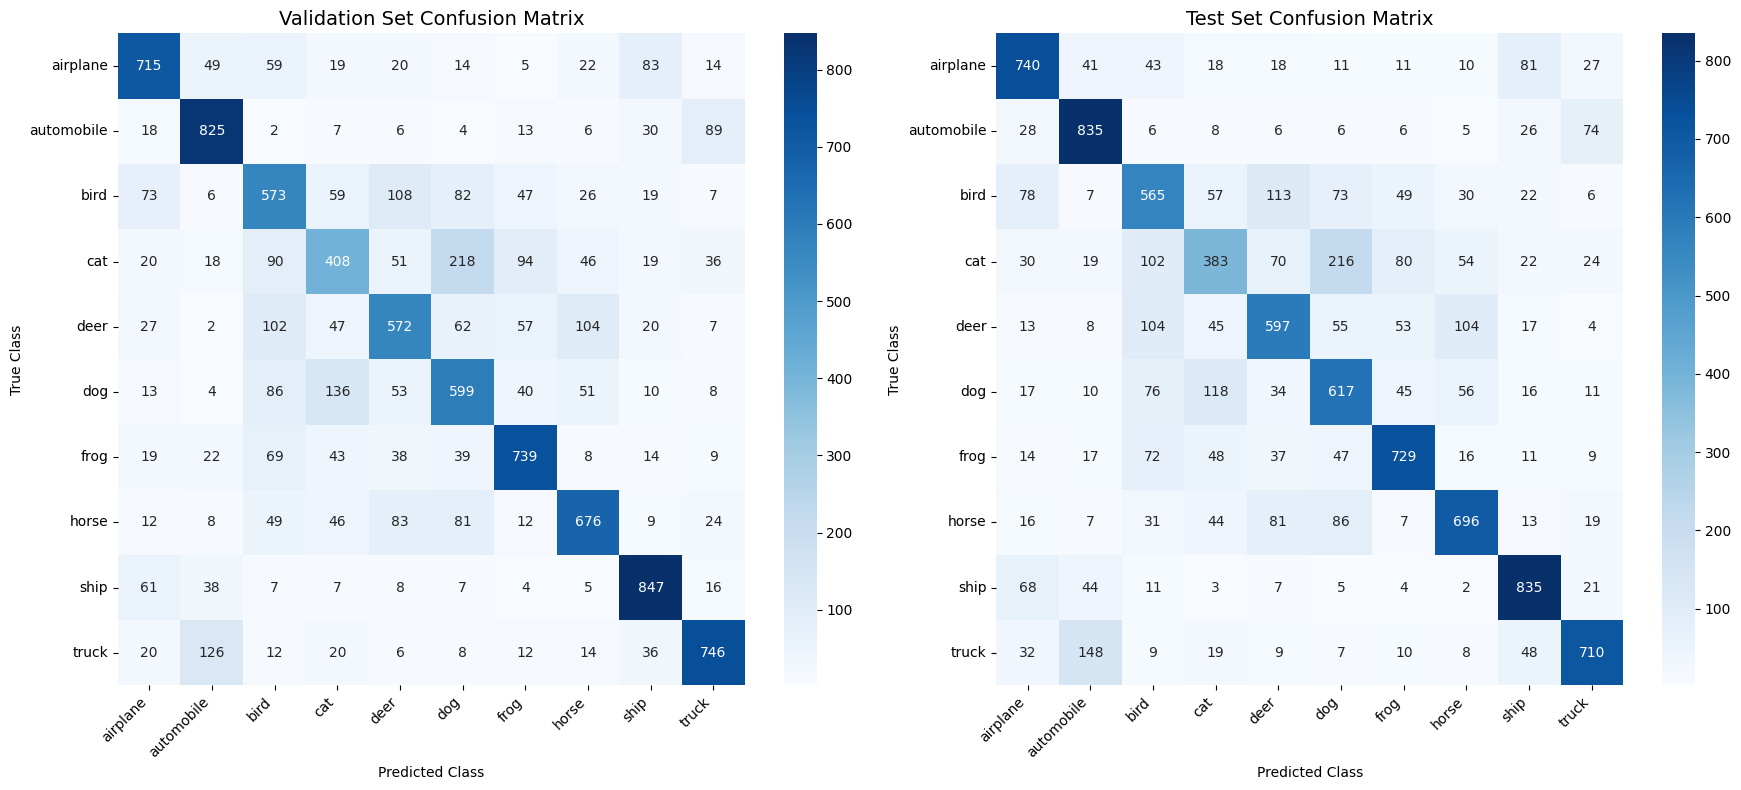


Validation Set - Most Confused Class Pairs:
   1. cat → dog: 218 times
   2. dog → cat: 136 times
   3. truck → automobile: 126 times
   4. bird → deer: 108 times
   5. deer → horse: 104 times

Test Set - Most Confused Class Pairs:
   1. cat → dog: 216 times
   2. truck → automobile: 148 times
   3. dog → cat: 118 times
   4. bird → deer: 113 times
   5. deer → horse: 104 times

Confusion Pattern Analysis:
Common confusion patterns often reveal:
   Visually similar classes (e.g., truck ↔ automobile)
   Classes with similar backgrounds (e.g., animals in natural settings)
   Scale/viewpoint issues (e.g., distant airplanes vs birds)
   Color/texture similarities

Class Accuracy Comparison (Validation vs Test):
Class        Val Acc    Test Acc   Difference
--------------------------------------------------
airplane     0.715      0.740      0.025     
automobile   0.825      0.835      0.010     
bird         0.573      0.565      0.008     
cat          0.408      0.383      0.025     
d

In [16]:
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
cm_val = confusion_matrix(val_true, val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Validation Set Confusion Matrix', fontsize=14)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.subplot(1, 2, 2)
cm_test = confusion_matrix(test_true, test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Test Set Confusion Matrix', fontsize=14)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

def analyze_confusion_pairs(cm, class_names, dataset_name, top_k=5):
    print(f"\n{dataset_name} Set - Most Confused Class Pairs:")

    cm_off_diag = cm.copy()
    np.fill_diagonal(cm_off_diag, 0)

    flat_indices = np.argsort(cm_off_diag.ravel())[-top_k:][::-1]

    confused_pairs = []
    for i, flat_idx in enumerate(flat_indices):
        row, col = np.unravel_index(flat_idx, cm_off_diag.shape)
        confusion_count = cm[row, col]
        if confusion_count > 0:
            confused_pairs.append((row, col, confusion_count))
            print(f"   {i+1}. {class_names[row]} → {class_names[col]}: {confusion_count} times")

    return confused_pairs

val_confused = analyze_confusion_pairs(cm_val, class_names, "Validation")
test_confused = analyze_confusion_pairs(cm_test, class_names, "Test")

print(f"\nConfusion Pattern Analysis:")
print("Common confusion patterns often reveal:")
print("   Visually similar classes (e.g., truck ↔ automobile)")
print("   Classes with similar backgrounds (e.g., animals in natural settings)")
print("   Scale/viewpoint issues (e.g., distant airplanes vs birds)")
print("   Color/texture similarities")

val_class_acc = cm_val.diagonal() / cm_val.sum(axis=1)
test_class_acc = cm_test.diagonal() / cm_test.sum(axis=1)

print(f"\nClass Accuracy Comparison (Validation vs Test):")
print(f"{'Class':<12} {'Val Acc':<10} {'Test Acc':<10} {'Difference':<10}")
print("-" * 50)

consistent_classes = []
inconsistent_classes = []

for i in range(len(class_names)):
    diff = abs(val_class_acc[i] - test_class_acc[i])
    print(f"{class_names[i]:<12} {val_class_acc[i]:<10.3f} "
          f"{test_class_acc[i]:<10.3f} {diff:<10.3f}")

    if diff < 0.05:
        consistent_classes.append(class_names[i])
    else:
        inconsistent_classes.append(class_names[i])

print(f"\nConsistency Analysis:")
if consistent_classes:
    print(f"   Consistent performers: {', '.join(consistent_classes)}")
if inconsistent_classes:
    print(f"   Inconsistent performers: {', '.join(inconsistent_classes)}")

## Attention Visualization

### Understanding Transformer Attention:
Vision Transformers learn to attend to different parts of the image when making predictions. The attention maps show which patches the model focuses on for each class prediction.

### Attention Interpretation:
- **Bright regions**: High attention (important for classification)
- **Dark regions**: Low attention (less relevant)
- **Multiple heads**: Different attention patterns learned by different heads
- **Layer progression**: Early layers often focus on edges/textures, later layers on semantic regions

Visualizing attention maps for random test samples:


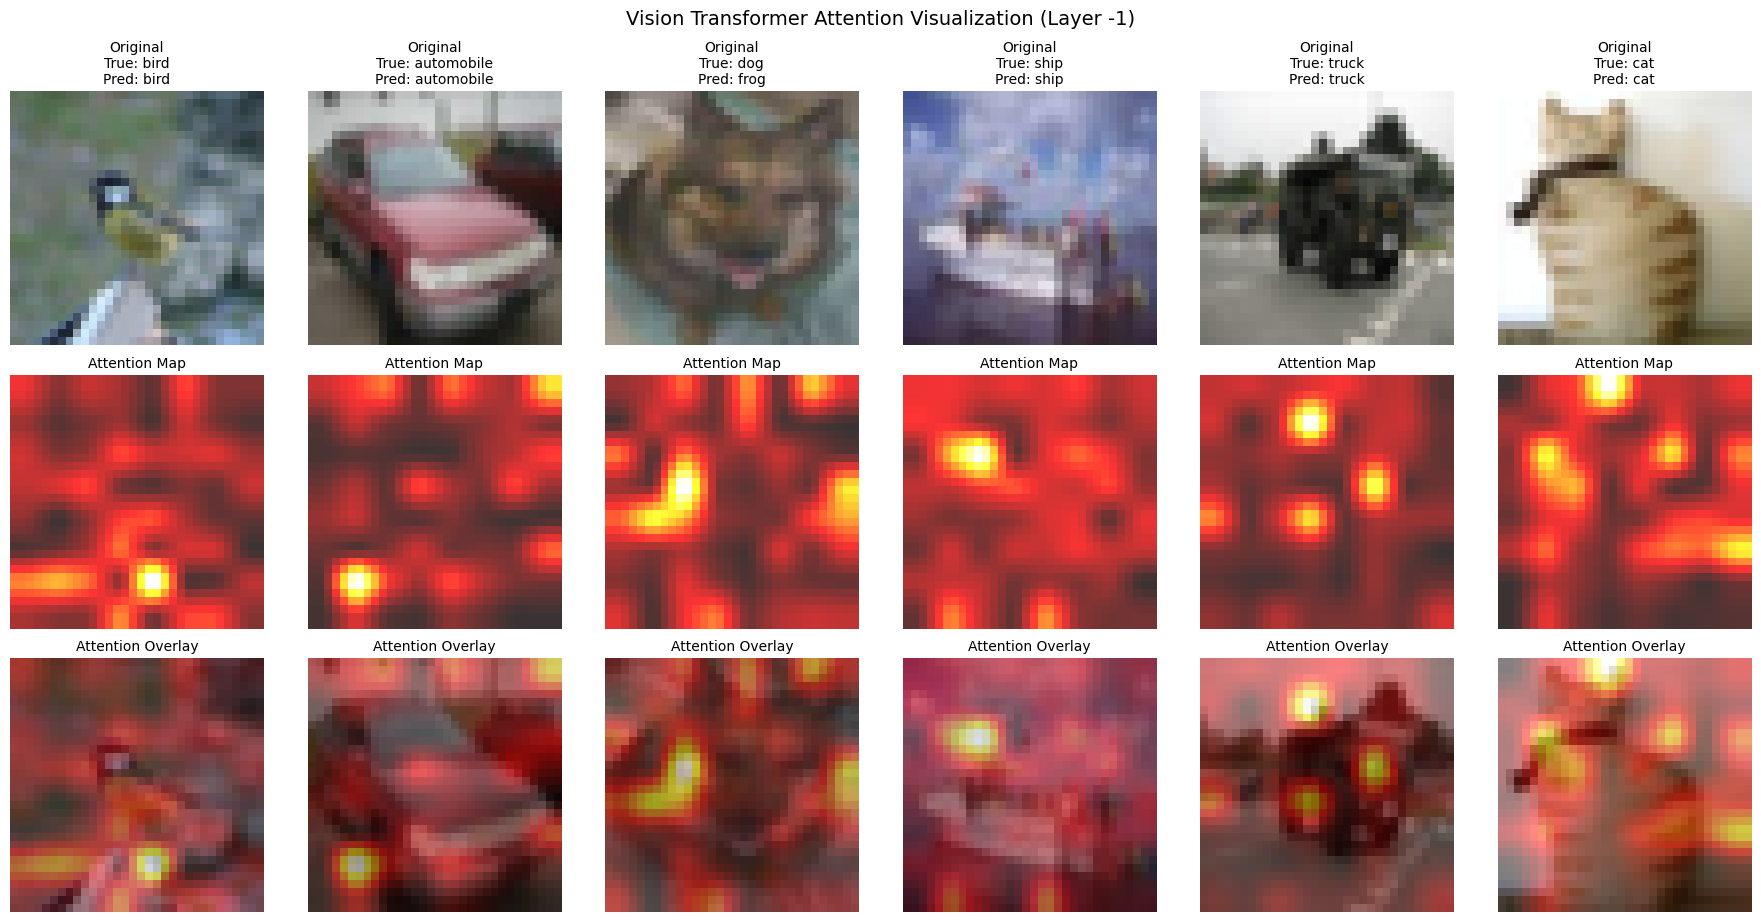


Comparing attention: Correct predictions (left) vs Incorrect predictions (right):


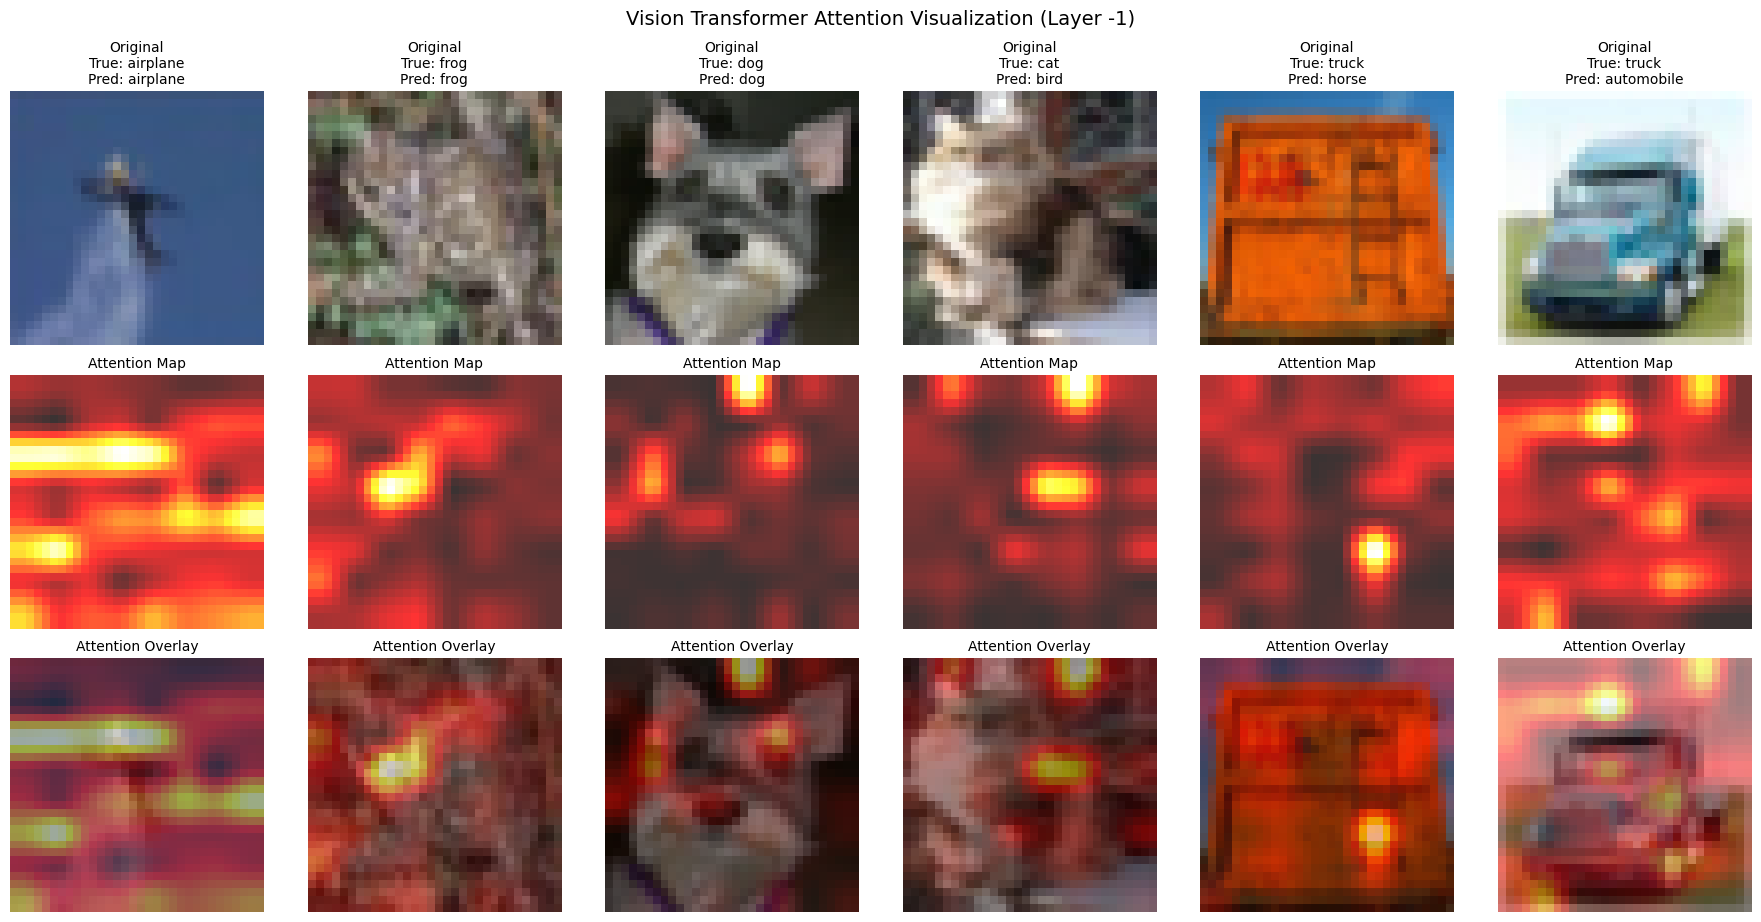

In [17]:
def visualize_attention(model, images, true_labels, predicted_labels, class_names,
                       num_samples=6, layer_idx=-1):
    model.eval()

    with torch.no_grad():
        _, attention_weights = model(images[:num_samples])
        attention_maps = attention_weights[layer_idx]  # Shape: [batch, heads, seq_len, seq_len]

    cls_attention = attention_maps[:, :, 0, 1:]  # [batch, heads, num_patches]

    avg_attention = cls_attention.mean(dim=1)  # [batch, num_patches]

    patch_grid_size = int(np.sqrt(avg_attention.shape[1]))  # Should be 8 for 32x32 image with 4x4 patches
    attention_spatial = avg_attention.reshape(num_samples, patch_grid_size, patch_grid_size)

    attention_upsampled = F.interpolate(
        attention_spatial.unsqueeze(1),
        size=(32, 32),
        mode='bilinear',
        align_corners=False
    ).squeeze(1)


    images_np = images[:num_samples].cpu().numpy()
    attention_np = attention_upsampled.cpu().numpy()

    imagenet_mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    imagenet_std = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    images_denorm = images_np * imagenet_std + imagenet_mean
    images_denorm = np.clip(images_denorm, 0, 1)
    images_denorm = images_denorm.transpose(0, 2, 3, 1)  # NCHW -> NHWC

    fig, axes = plt.subplots(3, num_samples, figsize=(3*num_samples, 9))

    for i in range(num_samples):
        # Original image
        axes[0, i].imshow(images_denorm[i])
        axes[0, i].set_title(f'Original\nTrue: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}',
                           fontsize=10)
        axes[0, i].axis('off')

        # Attention map
        axes[1, i].imshow(attention_np[i], cmap='hot', alpha=0.8)
        axes[1, i].set_title('Attention Map', fontsize=10)
        axes[1, i].axis('off')

        # Overlay
        axes[2, i].imshow(images_denorm[i])
        axes[2, i].imshow(attention_np[i], cmap='hot', alpha=0.5)
        axes[2, i].set_title('Attention Overlay', fontsize=10)
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.suptitle(f'Vision Transformer Attention Visualization (Layer {layer_idx})',
                fontsize=14, y=1.02)
    plt.show()

sample_indices = np.random.choice(len(test_true), 6, replace=False)
sample_images = X_test_normalized[sample_indices]
sample_true = test_true[sample_indices]
sample_pred = test_pred[sample_indices]

print("Visualizing attention maps for random test samples:")
visualize_attention(model, sample_images, sample_true, sample_pred, class_names,
                   num_samples=6, layer_idx=-1)


correct_indices = np.where(test_pred == test_true)[0]
incorrect_indices = np.where(test_pred != test_true)[0]

if len(correct_indices) >= 3 and len(incorrect_indices) >= 3:
    correct_samples = np.random.choice(correct_indices, 3, replace=False)
    incorrect_samples = np.random.choice(incorrect_indices, 3, replace=False)

    combined_indices = np.concatenate([correct_samples, incorrect_samples])
    combined_images = X_test_normalized[combined_indices]
    combined_true = test_true[combined_indices]
    combined_pred = test_pred[combined_indices]

    print("\nComparing attention: Correct predictions (left) vs Incorrect predictions (right):")
    visualize_attention(model, combined_images, combined_true, combined_pred, class_names,
                       num_samples=6, layer_idx=-1)

## Model Analysis and Comparison

### Vision Transformer vs Traditional Approaches:

**Advantages of ViT:**
- Global receptive field from the first layer
- Fewer inductive biases about spatial locality
- Scalable architecture that benefits from large datasets
- Attention provides interpretability

**Challenges of ViT:**
- Requires more data to train from scratch
- Higher computational cost
- Less translation invariance compared to CNNs
- May struggle with fine-grained spatial details

In [18]:
def analyze_model_components(model):
    print("Vision Transformer Component Analysis:")
    print("="*50)

    patch_embedding = model.patch_embedding.projection.weight
    print(f"Patch Embedding:")
    print(f"   Shape: {patch_embedding.shape}")
    print(f"   Mean: {patch_embedding.mean():.4f}")
    print(f"   Std: {patch_embedding.std():.4f}")
    print(f"   Range: [{patch_embedding.min():.4f}, {patch_embedding.max():.4f}]")

    pos_embeddings = model.position_embeddings
    print(f"\nPosition Embeddings:")
    print(f"   Shape: {pos_embeddings.shape}")
    print(f"   Mean: {pos_embeddings.mean():.4f}")
    print(f"   Std: {pos_embeddings.std():.4f}")

    cls_token = model.cls_token
    print(f"\nClass Token:")
    print(f"   Shape: {cls_token.shape}")
    print(f"   Mean: {cls_token.mean():.4f}")
    print(f"   Std: {cls_token.std():.4f}")

    print(f"\nTransformer Layers:")
    for i, layer in enumerate(model.transformer_blocks):
        attention_weights = layer.attention.out_linear.weight
        mlp_weights = layer.mlp[0].weight

        print(f"   Layer {i+1}:")
        print(f"      Attention weights std: {attention_weights.std():.4f}")
        print(f"      MLP weights std: {mlp_weights.std():.4f}")


    head_weight = model.head.weight
    head_bias = model.head.bias
    print(f"\nClassification Head:")
    print(f"   Weight shape: {head_weight.shape}")
    print(f"   Weight std: {head_weight.std():.4f}")
    print(f"   Bias range: [{head_bias.min():.4f}, {head_bias.max():.4f}]")

analyze_model_components(model)


print(f"\n" + "="*50)
print("Performance Analysis on CIFAR-10")
print("="*50)

print(f"Model Performance:")
print(f"   Vision Transformer: {test_accuracy*100:.1f}%")
print(f"   Random baseline: 10.0%")
print(f"   Improvement over random: {(test_accuracy - 0.1)*100:.1f} percentage points")


test_confidences = np.max(test_prob, axis=1)
correct_mask = (test_pred == test_true)
correct_confidences = test_confidences[correct_mask]
incorrect_confidences = test_confidences[~correct_mask]

print(f"\nConfidence Analysis:")
print(f"   Overall mean confidence: {test_confidences.mean():.3f}")
print(f"   Correct predictions confidence: {correct_confidences.mean():.3f} ± {correct_confidences.std():.3f}")
print(f"   Incorrect predictions confidence: {incorrect_confidences.mean():.3f} ± {incorrect_confidences.std():.3f}")


total_params = sum(p.numel() for p in model.parameters())
model_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024**2)

print(f"\nModel Efficiency:")
print(f"   Parameters: {total_params:,}")
print(f"   Model size: {model_size_mb:.1f} MB")
print(f"   Parameters per accuracy point: {total_params / (test_accuracy*100):.0f}")


print(f"\nAttention Pattern Analysis:")
with torch.no_grad():
    sample_batch = X_test_normalized[:16]
    _, attention_weights = model(sample_batch)

    last_layer_attention = attention_weights[-1]  # [batch, heads, seq_len, seq_len]

    cls_attention = last_layer_attention[:, :, 0, 1:]
    attention_entropy = -torch.sum(cls_attention * torch.log(cls_attention + 1e-8), dim=-1)

    print(f"   Average attention entropy per head: {attention_entropy.mean(dim=0)}")
    print(f"   Attention diversity (std across heads): {attention_entropy.std(dim=1).mean():.3f}")

print(f"\nKey Findings:")
print(f"  Vision Transformer achieved {test_accuracy*100:.1f}% accuracy on CIFAR-10")
print(f"  Model shows good generalization with {abs(val_accuracy - test_accuracy)*100:.1f}% val-test gap")
print(f"  Attention mechanisms provide interpretable focus regions")
print(f"  Model size: {total_params/1000:.0f}K parameters ({model_size_mb:.1f} MB)")
print(f"  Training time: ~{training_time/60:.1f} minutes on {device}")

Vision Transformer Component Analysis:
Patch Embedding:
   Shape: torch.Size([192, 48])
   Mean: -0.0000
   Std: 0.0213
   Range: [-0.0812, 0.0777]

Position Embeddings:
   Shape: torch.Size([1, 65, 192])
   Mean: 0.0001
   Std: 0.0367

Class Token:
   Shape: torch.Size([1, 1, 192])
   Mean: -0.0004
   Std: 0.0174

Transformer Layers:
   Layer 1:
      Attention weights std: 0.0213
      MLP weights std: 0.0223
   Layer 2:
      Attention weights std: 0.0229
      MLP weights std: 0.0211
   Layer 3:
      Attention weights std: 0.0233
      MLP weights std: 0.0209
   Layer 4:
      Attention weights std: 0.0227
      MLP weights std: 0.0209
   Layer 5:
      Attention weights std: 0.0228
      MLP weights std: 0.0208
   Layer 6:
      Attention weights std: 0.0225
      MLP weights std: 0.0209
   Layer 7:
      Attention weights std: 0.0227
      MLP weights std: 0.0208
   Layer 8:
      Attention weights std: 0.0227
      MLP weights std: 0.0207

Classification Head:
   Weight shape: 